# Advanced Lane Finding

This project's goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

#### This is an sample image:
<img src='test_images/straight_lines1.jpg'>

#### The identified lane:
<img src='results/lane_founded_straight_line_1.png'>


## Pipeline

- Calibrate camera
    - Read input images
    - Plot input images
    - Test Calibration
- For each image:
    - Undistort an image
    - Image threasholding
    - Perspective transform
    - Lane detection
        - Histogram
        - Radius curvature
        - Plotting back the identified lanes on image 

### Required packages

In [1]:
# Opencv http://docs.opencv.org/3.0-beta/modules/refman.html
import cv2
print("Opencv version: {}".format(cv2.__version__))

# Glob - Unix style pathname pattern expansion 
# https://docs.python.org/2/library/glob.html
import glob

# Numpy http://www.numpy.org/
import numpy as np
print("Numpy version: {}".format(np.__version__))

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Opencv version: 3.2.0
Numpy version: 1.13.3


## Calibrate Camera
<a id='calibrate_camera'></a>

### Reading Input Images
<a id='input_images'></a>

In [2]:
from utils import image_utils
from utils import image_processing

images = image_utils.read_images("camera_cal")
images_gray = image_processing.convert_to_gray(images)

### Plotting the images
<a id='plot_input_images'></a>

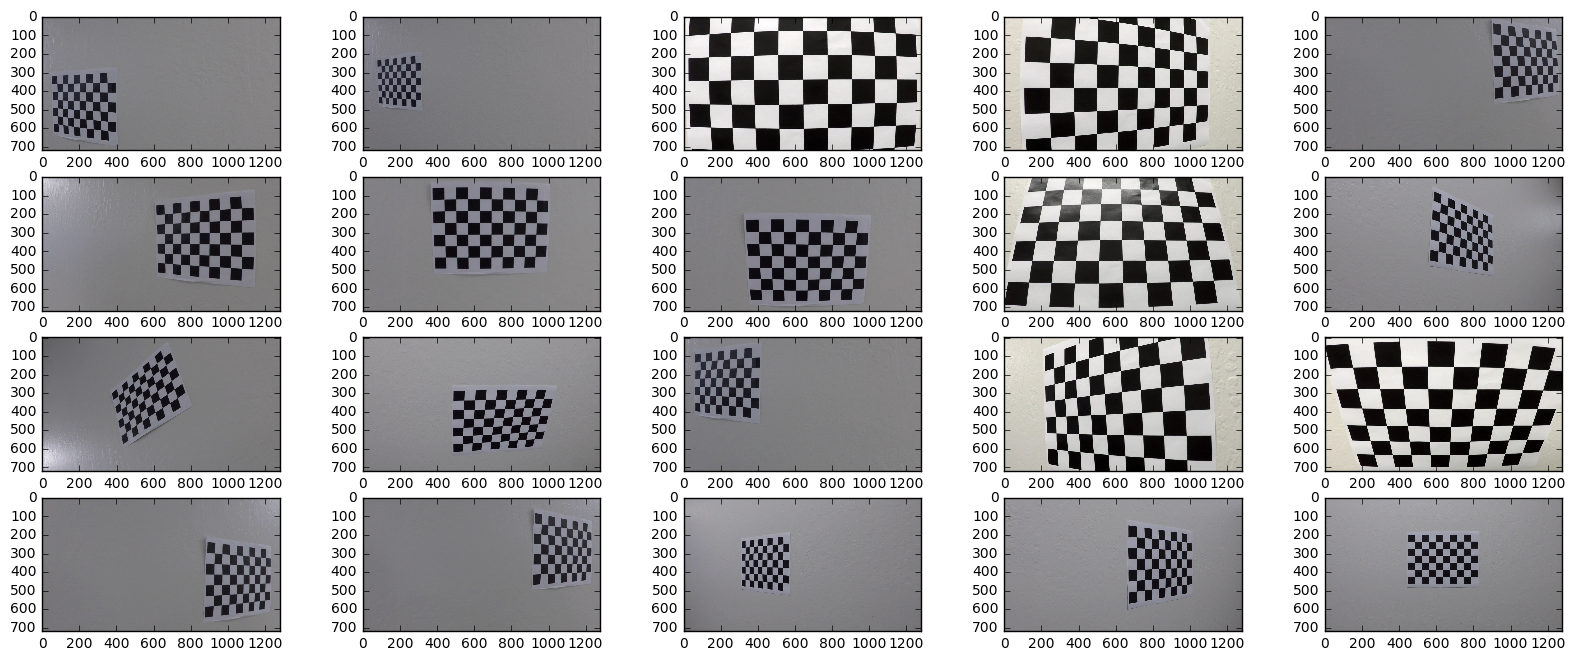

In [3]:
from utils import image_plotting

image_plotting.plot_images(images)

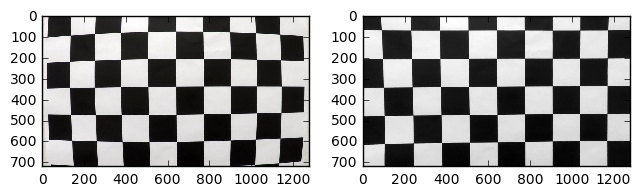

In [4]:
# Module for camera calibration
from utils import camera_calibration

# Calibrate Camera
cam_mtx, cam_dist = camera_calibration.camera_setup(images_gray)

# Undistort an image example
index = 2
undistorted_image = camera_calibration.undistort_image(images_gray[index], cam_mtx, cam_dist)
# image_plotting.plot_images([])
image_plotting.plot_images([images[index], undistorted_image], color_map='gray')

### Testing calibration
<a id='undistot_images'></a>

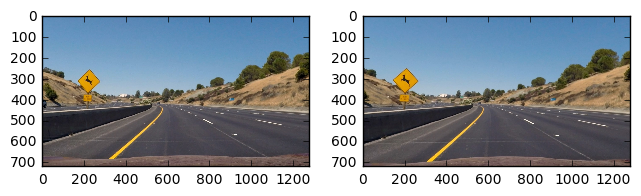

In [5]:
test_images = image_utils.read_images("test_images")
test_images_gray = image_processing.convert_to_gray(test_images)

# Undistort an image example
for index in range(1,2):
    undistorted_image = camera_calibration.undistort_image(test_images[index], cam_mtx, cam_dist)
    
    image_plotting.plot_images([test_images[index], undistorted_image], color_map='gray')

# Pipeline
<a id='for_each_image'></a>

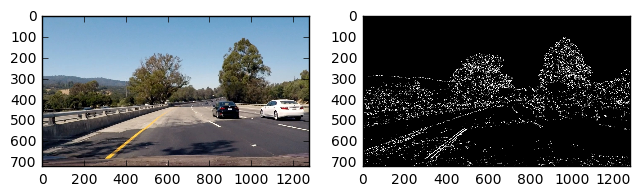

In [6]:
test_images_dir_threshold = []
test_images_mag_threshold = []
test_images_combined_threshold = []
ksize = 3
for image in test_images:
    image_dir = image_processing.dir_threshold(image)
    image_mag = image_processing.mag_thresh(image)
    
    gradx = image_processing.sobel_operator(image, orient='x', sobel_kernel=ksize, thresh_min=40, thresh_max=100)
    grady = image_processing.sobel_operator(image, orient='y', sobel_kernel=ksize, thresh_min=40, thresh_max=100)

    combined = np.zeros_like(image_dir)
    combined[((gradx == 1) & (grady == 1)) | ((image_mag == 1) & (image_dir == 1))] = 1
    
    test_images_dir_threshold.append(image_dir)
    test_images_mag_threshold.append(image_mag)
    test_images_combined_threshold.append(combined)
    
    
image_plotting.plot_images([test_images[0], test_images_combined_threshold[0]], color_map='gray')

## Binary Image

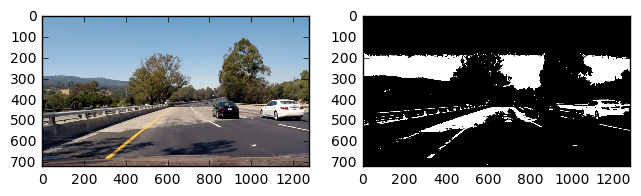

In [7]:
binary_image = image_processing.binary_operator(test_images[0])
image_plotting.plot_images([test_images[0], binary_image], color_map='gray')

# Color Spaces 

### RGB

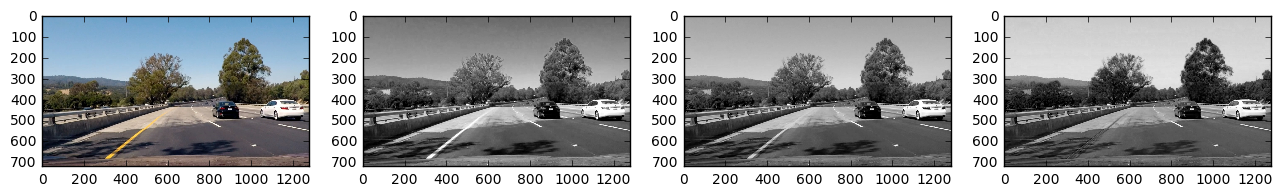

In [8]:
R = test_images[0][:,:,0]
G = test_images[0][:,:,1]
B = test_images[0][:,:,2]

image_plotting.plot_images([test_images[0], R, G, B], color_map='gray')

### HLS

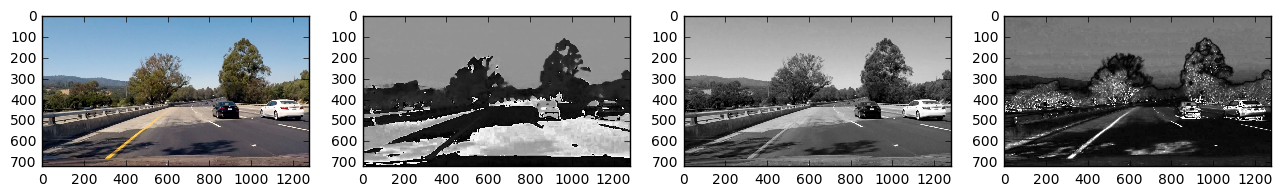

In [9]:
H, L, S = image_processing.convert_rgb_to_hls(test_images[0])

image_plotting.plot_images([test_images[0], H, L, S], color_map='gray')

### HSV

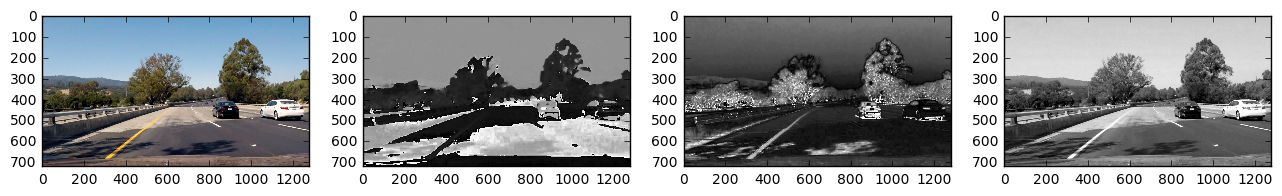

In [10]:
H, S, V = image_processing.convert_rgb_to_hsv(test_images[0])

image_plotting.plot_images([test_images[0], H, S, V], color_map='gray')

### Color and Gradient
<a id='color_and_gradient'></a>

In [11]:
def color_and_gradient(image):
    # Convert to HLS color space and separate the S channel
    _, _, S = image_processing.convert_rgb_to_hls(image)

    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sxbinary = image_processing.sobel_operator(image, orient='x', sobel_kernel=ksize, thresh_min=40, thresh_max=100)

    # Threshold color channel
    s_binary = image_processing.binary_operator(S, 170, 255)

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

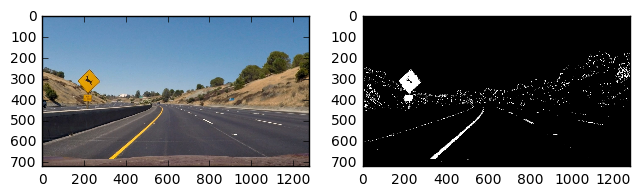

In [12]:
index = 1
combined_binary = color_and_gradient(test_images[index])

# Plotting the results
image_plotting.plot_images([test_images[index], combined_binary], color_map='gray')

### Perspective Transform
<a id='perspective_transform'></a>

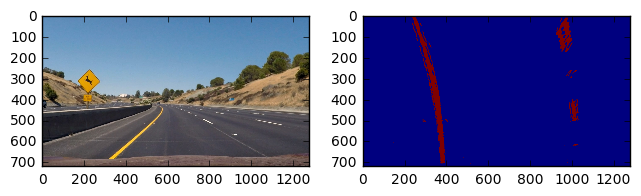

In [13]:
binary_warped, Minv = image_processing.perspective_transform(combined_binary)

# Plotting the results
image_plotting.plot_images([test_images[index], binary_warped])

### Histogram
<a id='histogram'></a>

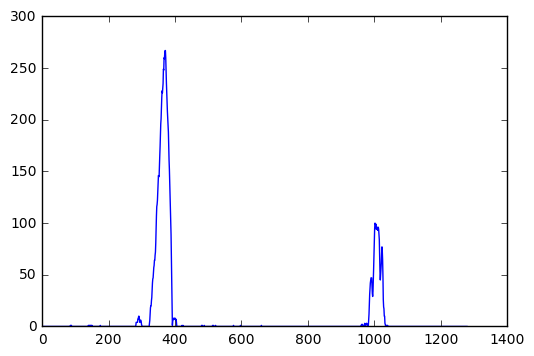

In [14]:
import numpy as np
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
im = plt.plot(histogram)

### Implement Sliding Windows and Fit a Polynomial
<a id='plot_back'></a>

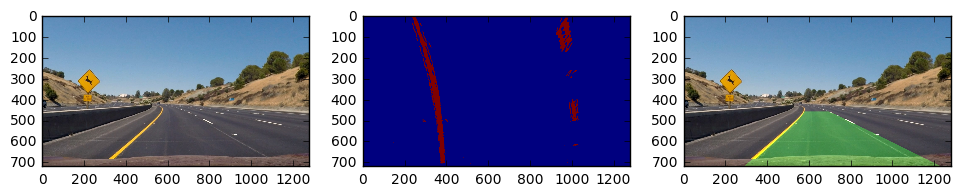

In [15]:
def sliding_window_polynomial(image, binary_warped, histogram, verbose = False):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenating the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ## Visualization
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Plotting the results
    if verbose:    
        image_plotting.plot_images([image, binary_warped, out_img])
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result, left_fit, right_fit

out_img, _, _ = sliding_window_polynomial(test_images[index], binary_warped, histogram)

image_plotting.plot_images([test_images[index], binary_warped, out_img])

## Curvature
<a id='curvature'></a>

In [16]:
def get_curvature(left_fit, right_fit):
    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
    y_eval = 700
    midx = 650

    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)

    return curvature

In [23]:
def pipeline(image, verbose = False):
    
    # ---- Binary
    combined_binary = color_and_gradient(image)

    # Plotting the results
    if verbose:
        image_plotting.plot_images([image, combined_binary], color_map='gray')

    # ---- Perspective Transform
    binary_warped, Minv = image_processing.perspective_transform(combined_binary)

    # Plotting the results
    if verbose:    
        image_plotting.plot_images([image, binary_warped])
    
    # ---- Histogram
    import numpy as np
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    
    # ---- Sliding Window and Fitting a Polynomial 
    result, left_fit, right_fit = sliding_window_polynomial(image, binary_warped, histogram, verbose)

    # ---- Curvature 
    curvature = get_curvature(left_fit, right_fit)
    if verbose:
        print("Radius of Curvature: %f" % curvature)

    return result

Radius of Curvature: 627.656655


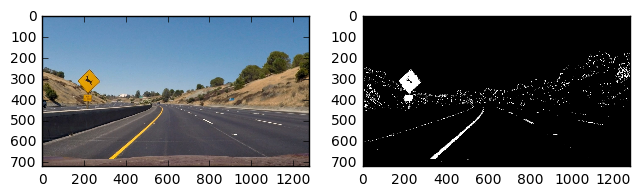

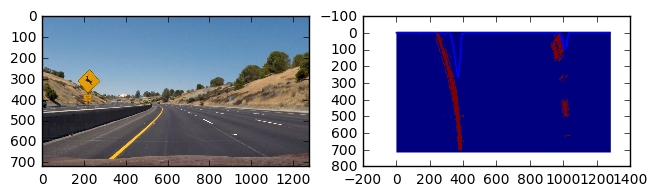

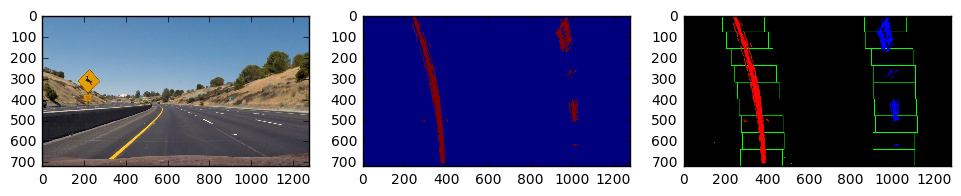

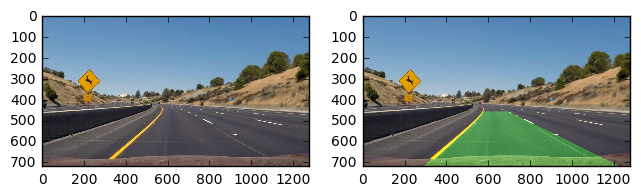

In [24]:
index = 1
result = pipeline(test_images[index], verbose = True)
image_plotting.plot_images([test_images[index], result])

### Video

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [01:31<00:00, 14.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 15s, sys: 5.93 s, total: 2min 21s
Wall time: 1min 31s


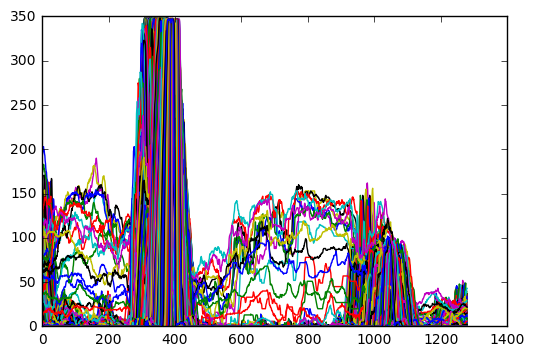

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# line=Line()
# Pipeline.set_values(line, M, Minv, cameraMat, distCoeffs)

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))